#Department of Technology Management and Innovation

#MG-GY 9753 – MOT4 Machine Learning

### Bhavish Venkatesh (bv643@nyu.edu)

### New York University

### May 15, 2020

### Submitted to Prof. H. Kone, Ph.D

## Final Project on `Customer Segmentation on Online Retail Database`






This Project aims at analyzing the content of an E-commerce database that lists purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

# Table of Contents

1. Data Preparation

2. Exploring the content of variables

3. Product Categories 

  3.1 Product description

  3.2 Defining product categories

  3.2.1 Data encoding

  3.2.2 Clusters of products

  3.2.3 Characterizing the content of clusters

4. Customer categories

  4.1 Formating data

  4.1.1 Grouping products

  4.1.2 Time spliting of the dataset

  4.1.3 Grouping orders

  4.2 Creating customer categories

  4.2.1 Data enconding

  4.2.2 Creating categories

5. Classifying customers

  5.1 Support Vector Machine Classifier (SVC)

  5.1.1 Confusion matrix

  5.1.2 Leraning curves

  5.2 Logistic regression

  5.3 k-Nearest Neighbors

  5.4 Decision Tree

  5.5 Random Forest

  5.6 AdaBoost

  5.7 Gradient Boosting Classifier

  5.8 Choose the best classifier

6. Testing the predictions

7. Conclusion

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
import math
import cvxopt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import GridSearchCV, learning_curve
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1.Data Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#filename = "data.csv"
filename = "/content/drive/My Drive/2 SEM/Machine Learning for Business/Project/data.csv"
df = pd.read_csv(filename, encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


While looking at the number of null values in the dataframe, it is interesting to note that $\sim$25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe

In [4]:
# Converting to datetime class
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  
# Removing NA's and Duplicate entries
df.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print(df.duplicated().sum())
df.drop_duplicates(inplace = True)
print('Dataframe dimensions:', df.shape)

5225
Dataframe dimensions: (401604, 8)


---


# 2.Exploring the content of variables

  **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

  **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

  **Description**: Product (item) name. Nominal.

 **Quantity**: The quantities of each product (item) per transaction. Numeric.

  **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.

  **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.

  **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

  **Country**: Country name. Nominal, the name of the country where each customer resides.

### 2.1 Countries


In [5]:
temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
print(temp['Country'].value_counts())

United Kingdom          19857
Germany                   603
France                    458
EIRE                      319
Belgium                   119
Spain                     105
Netherlands               101
Switzerland                71
Portugal                   70
Australia                  69
Italy                      55
Finland                    48
Sweden                     46
Norway                     40
Channel Islands            33
Japan                      28
Poland                     24
Denmark                    21
Cyprus                     20
Austria                    19
Malta                      10
Singapore                  10
Unspecified                 8
Iceland                     7
USA                         7
Greece                      6
Canada                      6
Israel                      6
European Community          5
Czech Republic              5
Lithuania                   4
United Arab Emirates        3
Saudi Arabia                2
Bahrain   

Transactions is largely dominated by United Kingdom

___
### 2.2 Customers and products

In [6]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of  ∼ 22'000.

Now I will determine the number of products purchased in every transaction

In [7]:
#number of products purchased in every transaction

temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order




In [8]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


___
#### 2.2.1 Cancelling orders

First of all, I count the number of transactions corresponding to canceled orders:

In [9]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


16% of the total orders were cancelled

On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [10]:
df_check = df[df['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT SATISFIED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT SATISFIED


We see that the initial hypothesis is not SATISFIED because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries:

In [11]:
df_check = df[(df['Quantity'] < 0) & (df['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df[(df['CustomerID'] == col[0]) & (df['Quantity'] == -col[1]) 
                & (df['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT SATISFIED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT SATISFIED


Once more, we find that the initial hypothesis is not verified. We can conclude that cancellations do not necessarily correspond to orders that would have been made beforehand

So now we check for two cases:

1. a cancel order exists without counterpart (reorder)
2. If there is atleast one counterpart with the exact same quantity (which becomes a new order)

In [12]:
df_cleaned = df.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df[(df['CustomerID'] == col['CustomerID']) &
                         (df['StockCode']  == col['StockCode']) & 
                         (df['InvoiceDate'] < col['InvoiceDate']) & 
                         (df['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

#The index of the corresponding cancel order are respectively kept in the 
# `doubtfull_entry` and `entry_to_remove` lists whose sizes are 

print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))       

entry_to_remove: 7521
doubtfull_entry: 1226


In [13]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


___
#### 2.2.2 StockCode

Some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for Discount).

In [14]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


___
#### 2.2.3 Total Price Calculation


In [15]:
#Total Price or Basket Price Calculation

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


---
#### 2.2.4 Grouping by Order

Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [16]:

temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
total_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
total_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

total_price = total_price[total_price['Basket Price'] > 0]
total_price.sort_values('CustomerID').head()

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000


In order to have a global view of the type of order performed in this dataset, I determine how the purchases are divided according to total prizes

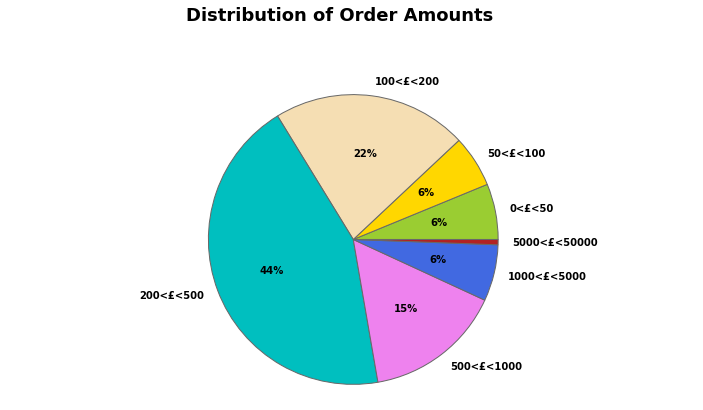

In [17]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = total_price[(total_price['Basket Price'] < price) &
                       (total_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<£<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of Order Amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases give prizes in excess of £ 200.

# 3.1 Clustering on Product Categories

This clustering is based on the Product Description

Defining a function to returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

In [0]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Number of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [19]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [20]:
df_products = pd.DataFrame(df['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Number of keywords in variable 'Description': 1483


In [0]:
list1 = sorted(list_products, key = lambda x:x[1], reverse = True)

In [22]:
#Defining Product Categories
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
list1_products = df_cleaned['Description'].unique()
print('Words Kept:', len(list_products))

Words Kept: 193


In [0]:
# X is the new dataframe with key value mapping
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list1_products))

In [0]:
# Segmenting the price into 6 groups to make it 
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
# Defining the threshold for the rows
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0
#Iterrating and assigning the group number the transactions
for i, prod in enumerate(list1_products):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [25]:
# Printing the number of products in different groups
print("{:<8} {:<20} \n".format('Group', 'No. of Products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Group    No. of Products      
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


## 3.1 KMeans Algorithm to cluster products

Using silhouette score to validate the clusters (work to be done)

https://en.wikipedia.org/wiki/Silhouette_(clustering)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [0]:
##### KMeans Algorithm #####
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def euclidean_distance(x1, x2):
    """ Calculates the l2 distance between two vectors """
    distance = 0
    # Squared distance between each coordinate
    for i in range(len(x1)):
        distance += pow((x1[i] - x2[i]), 2)
    return math.sqrt(distance)

class KMeans():
    """A simple clustering method that forms k clusters by iteratively reassigning
    samples to the closest centroids and after that moves the centroids to the center
    of the new formed clusters.
    """
    def __init__(self, k=2, max_iterations=500):
        self.k = k
        self.max_iterations = max_iterations

    def _init_random_centroids(self, X):
        """ Initialize the centroids as k random samples of X"""
        n_samples, n_features = np.shape(X)
        centroids = np.zeros((self.k, n_features))
        for i in range(self.k):
            centroid = X[np.random.choice(range(n_samples))]
            centroids[i] = centroid
        return centroids

    def _closest_centroid(self, sample, centroids):
        """ Return the index of the closest centroid to the sample """
        closest_i = 0
        closest_dist = float('inf')
        for i, centroid in enumerate(centroids):
            distance = euclidean_distance(sample, centroid)
            if distance < closest_dist:
                closest_i = i
                closest_dist = distance
        return closest_i

    def _create_clusters(self, centroids, X):
        """ Assign the samples to the closest centroids to create clusters """
        n_samples = np.shape(X)[0]
        clusters = [[] for _ in range(self.k)]
        for sample_i, sample in enumerate(X):
            centroid_i = self._closest_centroid(sample, centroids)
            clusters[centroid_i].append(sample_i)
        return clusters

    def _calculate_centroids(self, clusters, X):
        """ Calculate new centroids as the means of the samples in each cluster  """
        n_features = np.shape(X)[1]
        centroids = np.zeros((self.k, n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
        return centroids

    def _get_cluster_labels(self, clusters, X):
        """ Classify samples as the index of their clusters """
        # One prediction for each sample
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred

    def predict(self, X):
        """ Do K-Means clustering and return cluster indices """

        # Initialize centroids as k random samples from X
        centroids = self._init_random_centroids(X)

        # Iterate until convergence or for max iterations
        for _ in range(self.max_iterations):
            # Assign samples to closest centroids (create clusters)
            clusters = self._create_clusters(centroids, X)
            # Save current centroids for convergence check
            prev_centroids = centroids
            # Calculate new centroids from the clusters
            centroids = self._calculate_centroids(clusters, X)
            # If no centroids have changed => convergence
            diff = centroids - prev_centroids
            if not diff.any():
                break

        return self._get_cluster_labels(clusters, X)

In [27]:
matrix = X.to_numpy()
from sklearn.metrics import silhouette_samples, silhouette_score
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.12193090502536758
For n_clusters = 5 The average silhouette_score is : 0.14708700459493795
For n_clusters = 6 The average silhouette_score is : 0.14509988406712557
For n_clusters = 7 The average silhouette_score is : 0.13008580849503765
For n_clusters = 8 The average silhouette_score is : 0.16136085168920045
For n_clusters = 9 The average silhouette_score is : 0.13699035893426106


Ideal silhouette_score is the mean of all the clusters.

In [30]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145: 
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14740815062347604


In [31]:
pd.Series(clusters).value_counts()

0    1009
2     964
1     673
3     626
4     606
dtype: int64

These are the product clustered

# 4.Clustering of Customers

`categ_product` indicates the cluster of each product

In [0]:
corresp = dict()
for key, val in zip (list1_products, clusters):
    corresp[key] = val 
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

`categ_N` variable (with  N∈[0:4] ) that contains the amount spent in each product category

In [33]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.0,15.3,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [34]:
#_______________________________________________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket_Price'})
#_______________________________________________________________________________
# percentage of the order price / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_______________________________________________________________________________
# date of the order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#_______________________________________________________________________________
# selection of significant entries
basket_price = basket_price[basket_price['Basket_Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket_Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,187.2,83.40,23.40,124.44,293.35,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,130.5,53.10,84.34,38.25,169.20,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,330.9,71.10,81.00,38.25,115.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,74.4,78.06,41.40,19.90,168.76,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,109.7,119.70,61.30,136.05,158.16,2011-08-02 08:48:00.000000000


Separating data over time

In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it

In [35]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [0]:
set_train = basket_price[basket_price['InvoiceDate'] < pd.Timestamp(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.Timestamp(2011,10,1)]
basket_price = set_train.copy(deep = True)

Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits

In [37]:
#________________________________________________________________
# number of visits and stats on the basket amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket_Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,14.524555,10.442659,12.787815,32.408290
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,38.016069,20.030714,0.000000
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,27.900718,11.692584,11.961722,0.000000
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,3.370331,0.491808,67.534402,15.711338
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,19.887640,0.000000,67.078652,0.000000


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase ) and the number of days since the last purchase ( LastPurchase **):

In [38]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,29.836681,14.524555,10.442659,12.787815,32.408290,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,38.016069,20.030714,0.000000,5,288
2,12350,1,334.40,334.40,334.400000,334.40,48.444976,27.900718,11.692584,11.961722,0.000000,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,12.892120,3.370331,0.491808,67.534402,15.711338,2,226
4,12353,1,89.00,89.00,89.000000,89.00,13.033708,19.887640,0.000000,67.078652,0.000000,134,134


In [39]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Number of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Number of customers with single purchase: 1445/3608  (40.05%)


Time to create Customer Categories for easy clustering

In [0]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_______________________________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

The different variables I selected have quite different ranges of variation and before continuing the analysis therefore standarding the dataframe

In [41]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  25.22916919
  21.19884856  13.98907929  23.21847344  16.37327913]


## 4.1.PCA

In [0]:
##### Function for PCA #####
class PCA():
    """A method for doing dimensionality reduction by transforming the feature
    space to a lower dimensionality, removing correlation between features and
    maximizing the variance along each feature axis. This class is also used throughout
    the project to plot data.
    """
    def transform(self, X, n_components):
        """ Fit the dataset to the number of principal components specified in the
        constructor and return the transformed dataset """
        covariance_matrix = calculate_covariance_matrix(X)

        # Where (eigenvector[:,0] corresponds to eigenvalue[0])
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

        # Sort the eigenvalues and corresponding eigenvectors from largest
        # to smallest eigenvalue and select the first n_components
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:n_components]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :n_components]

        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed

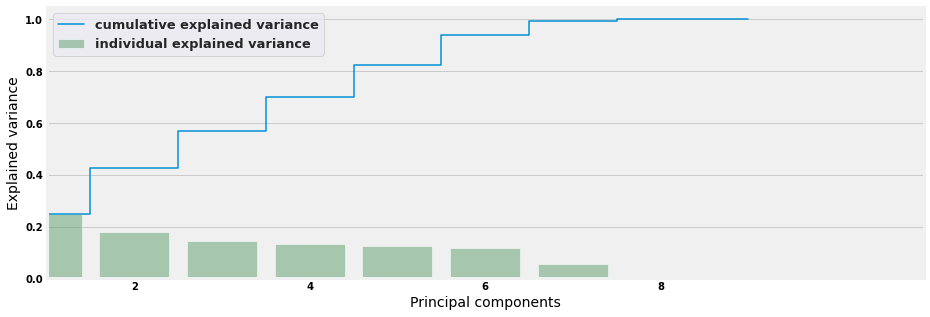

In [43]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_matrix)
#Amount of variance in each component
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

The curve flattens beyond 10. k=11 shows the least variance in the components. Therefore number of clusters =11.


In [44]:
n_clusters = 11
from sklearn.cluster import KMeans
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['Number of customers']).T

silhouette score: 0.216


,0,1,5,4,10,6,2,7,8,3,9
Number of customers,1461,508,459,310,287,229,183,147,9,8,7


silhouette among the different samples of clusters


In [0]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

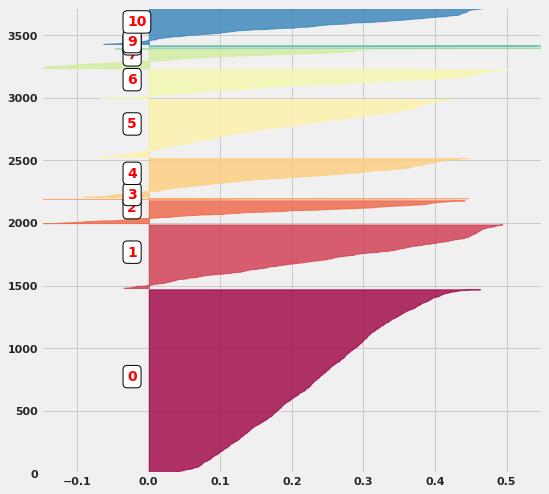

In [46]:
from sklearn.metrics import silhouette_samples, silhouette_score
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each client belongs:

In [0]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [48]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [49]:
## dropping this part #######

liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,5.0,2.433551,214.057996,327.948455,267.471108,667.033074,57.283777,12.827031,12.751594,9.470712,7.670130,459
1,10.0,2.578397,211.335679,375.124774,288.734799,812.509652,14.810284,61.314523,6.988318,10.015622,6.871253,287
2,6.0,2.170306,193.157031,314.577205,245.215838,574.275590,17.975794,10.981077,57.755390,7.261013,6.026725,229
3,1.0,2.618110,199.060652,345.261457,261.884366,710.679293,11.175143,10.890584,4.806908,62.297472,10.841000,508
4,4.0,2.125806,206.340452,337.455290,265.874749,654.209129,13.448154,14.027147,6.338576,15.956163,50.279925,310
5,0.0,3.305955,219.541192,462.030849,332.157648,1104.715490,25.808676,22.238585,14.105533,20.598380,17.252882,1461
6,2.0,1.737705,1075.547104,1461.395798,1248.963392,2329.767164,25.982917,21.382580,11.983077,23.510337,17.141457,183
7,8.0,1.222222,3901.461111,4064.098889,3982.780000,5032.047778,20.388127,11.852002,26.370713,26.857929,14.531229,9
8,7.0,18.612245,86.714558,1731.098435,594.153339,10505.643265,23.822835,25.426151,12.161687,22.329707,16.280937,147
9,9.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,25.832531,22.527857,13.117583,25.144909,13.402971,7


# 5.Algorithms

### 5.0 Machine Learning Utility Functions

In [0]:
##### Machine Learning Utility Functions #####

class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))


def plot_learning_curve1(estimator, title, X, y, axes=None, ylim=None, cv=None,
                         
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def accuracy_score(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
  return accuracy

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
  """ Split the data into train and test sets """
  if shuffle:
    X, y = shuffle_data(X, y, seed)
  # Split the training data from test data in the ratio specified in
  # test_size
  split_i = len(y) - int(len(y) // (1 / test_size))
  X_train, X_test = X[:split_i], X[split_i:]
  y_train, y_test = y[:split_i], y[split_i:]

  return X_train, X_test, y_train, y_test


def divide_on_feature(X, feature_i, threshold):

    """ Divide dataset based on if sample value on feature index is larger than
        the given threshold """
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])


def get_random_subsets(X, y, n_subsets, replacements=True):
    """ Return random subsets (with replacements) of the data """
    n_samples = np.shape(X)[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
    np.random.shuffle(X_y)
    subsets = []

    # Uses 50% of training samples without replacements
    subsample_size = int(n_samples // 2)
    if replacements:
        subsample_size = n_samples      # 100% with replacements

    for _ in range(n_subsets):
        idx = np.random.choice(
            range(n_samples),
            size=np.shape(range(subsample_size)),
            replace=replacements)
        X = X_y[idx][:, :-1]
        y = X_y[idx][:, -1]
        subsets.append([X, y])
    return subsets


def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std


def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    """ Split the data into train and test sets """
    if shuffle:
        X, y = shuffle_data(X, y, seed)
    # Split the training data from test data in the ratio specified in
    # test_size
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]

    return X_train, X_test, y_train, y_test


def k_fold_cross_validation_sets(X, y, k, shuffle=True):
    """ Split the data into k sets of training / test data """
    if shuffle:
        X, y = shuffle_data(X, y)

    n_samples = len(y)
    left_overs = {}
    n_left_overs = (n_samples % k)
    if n_left_overs != 0:
        left_overs["X"] = X[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        X = X[:-n_left_overs]
        y = y[:-n_left_overs]

    X_split = np.split(X, k)
    y_split = np.split(y, k)
    sets = []
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        sets.append([X_train, X_test, y_train, y_test])

    # Add left over samples to last set as training samples
    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["X"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return np.array(sets)


def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy


def accuracy_score(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
  return accuracy


class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time

In [0]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns] #independent variable
Y = selected_customers['cluster']  #dependent variable

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

### 5.1. Support Vector Classfier

In [0]:
# Hide cvxopt output
cvxopt.solvers.options['show_progress'] = False

def rbf_kernel(gamma, **kwargs):
    def f(x1, x2):
        distance = np.linalg.norm(x1 - x2) ** 2
        return np.exp(-gamma * distance)
    return f

class SupportVectorMachine(object):
    """The Support Vector Machine classifier.
    Uses cvxopt to solve the quadratic optimization problem.
    """
    def __init__(self, C=1, kernel=rbf_kernel, power=4, gamma=None, coef=4):
        self.C = C
        self.kernel = kernel
        self.power = power
        self.gamma = gamma
        self.coef = coef
        self.lagr_multipliers = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.intercept = None

    def fit(self, X, y):

        n_samples, n_features = np.shape(X)

        # Set gamma to 1/n_features by default
        if not self.gamma:
            self.gamma = 1 / n_features

        # Initialize kernel method with parameters
        self.kernel = self.kernel(
            power=self.power,
            gamma=self.gamma,
            coef=self.coef)

        # Calculate kernel matrix
        kernel_matrix = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                kernel_matrix[i, j] = self.kernel(X[i], X[j])

        # Define the quadratic optimization problem
        P = cvxopt.matrix(np.outer(y, y) * kernel_matrix, tc='d')
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1, n_samples), tc='d')
        b = cvxopt.matrix(0, tc='d')

        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            h = cvxopt.matrix(np.vstack((h_max, h_min)))

        # Solve the quadratic optimization problem using cvxopt
        minimization = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        lagr_mult = np.ravel(minimization['x'])

        # Extract support vectors
        # Get indexes of non-zero lagr. multipiers
        idx = lagr_mult > 1e-7
        # Get the corresponding lagr. multipliers
        self.lagr_multipliers = lagr_mult[idx]
        # Get the samples that will act as support vectors
        self.support_vectors = X[idx]
        # Get the corresponding labels
        self.support_vector_labels = y[idx]

        # Calculate intercept with first support vector
        self.intercept = self.support_vector_labels[0]
        for i in range(len(self.lagr_multipliers)):
            self.intercept -= self.lagr_multipliers[i] * self.support_vector_labels[
                i] * self.kernel(self.support_vectors[i], self.support_vectors[0])

    def predict(self, X):
        y_pred = []
        # Iterate through list of samples and make predictions
        for sample in X:
            prediction = 0
            # Determine the label of the sample by the support vectors
            for i in range(len(self.lagr_multipliers)):
                prediction += self.lagr_multipliers[i] * self.support_vector_labels[
                    i] * self.kernel(self.support_vectors[i], sample)
            prediction += self.intercept
            y_pred.append(np.sign(prediction))
        return np.array(y_pred)

In [53]:
svc = Class_Fit(clf =SupportVectorMachine)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)


Precision: 77.15 % 


___
#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [0]:
###### Function to plot Confusion Matrix ######

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


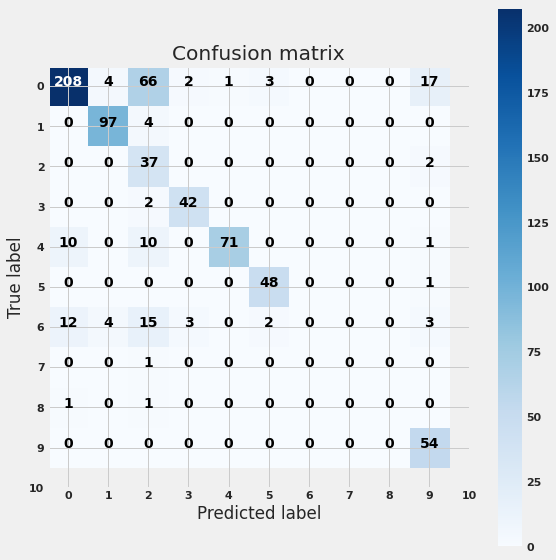

In [55]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
### 5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

### 5.2.1 Logistic Regression Algorithm

In [0]:
###### Logistic Regression Function ######
def make_diagonal(x):
    """ Converts a vector into an diagonal matrix """
    m = np.zeros((len(x), len(x)))
    for i in range(len(m[0])):
        m[i, i] = x[i]
    return m

class Sigmoid():
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))

    def gradient(self, x):
        return self.__call__(x) * (1 - self.__call__(x))

class LogisticRegression():
    """ Logistic Regression classifier.
  
    """
    def __init__(self, learning_rate=.1, gradient_descent=True):
        self.param = None
        self.learning_rate = learning_rate
        self.gradient_descent = gradient_descent
        self.sigmoid = Sigmoid()

    def _initialize_parameters(self, X):
        n_features = np.shape(X)[1]
        # Initialize parameters between [-1/sqrt(N), 1/sqrt(N)]
        limit = 1 / math.sqrt(n_features)
        self.param = np.random.uniform(-limit, limit, (n_features,))

    def fit(self, X, y, n_iterations=4000):
        self._initialize_parameters(X)
        # Tune parameters for n iterations
        for i in range(n_iterations):
            # Make a new prediction
            y_pred = self.sigmoid(X.dot(self.param))
            if self.gradient_descent:
                # Move against the gradient of the loss function with
                # respect to the parameters to minimize the loss
                self.param -= self.learning_rate * -(y - y_pred).dot(X)
            else:
                # Make a diagonal matrix of the sigmoid gradient column vector
                diag_gradient = make_diagonal(self.sigmoid.gradient(X.dot(self.param)))
                # Batch opt:
                self.param = np.linalg.pinv(X.T.dot(diag_gradient).dot(X)).dot(X.T).dot(diag_gradient.dot(X).dot(self.param) + y - y_pred)

    def predict(self, X):
        y_pred = np.round(self.sigmoid(X.dot(self.param))).astype(int)
        return y_pred

### 5.2.2 Logistic Regression Output

In [57]:
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 88.92 % 


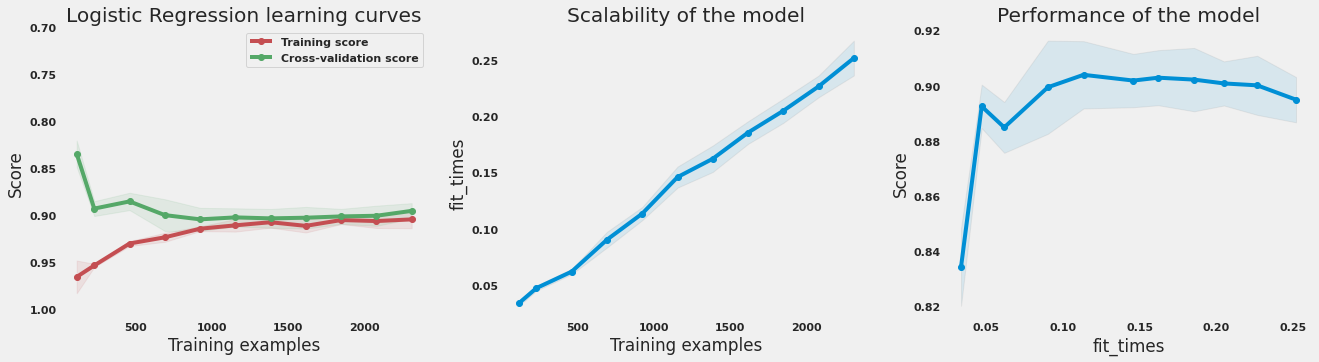

In [58]:
g = plot_learning_curve1(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [0]:
##### K Nearest Neighbors #####
class KNN():
    """ K Nearest Neighbors classifier.
 
    """
    def __init__(self, k=5):
        self.k = k

    def _vote(self, neighbor_labels):
        """ Return the most common class among the neighbor samples """
        counts = np.bincount(neighbor_labels.astype('int'))
        return counts.argmax()

    def predict(self, X_test, X_train, y_train):
        y_pred = np.empty(X_test.shape[0])
        # Determine the class of each sample
        for i, test_sample in enumerate(X_test):
            # Sort the training samples by their distance to the test sample and get the K nearest
            idx = np.argsort([euclidean_distance(test_sample, x) for x in X_train])[:self.k]
            # Extract the labels of the K nearest neighboring training samples
            k_nearest_neighbors = np.array([y_train[i] for i in idx])
            # Label sample as the most common class label
            y_pred[i] = self._vote(k_nearest_neighbors)

        return y_pred

In [60]:
knn = Class_Fit(clf = KNN)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 80.06 % 


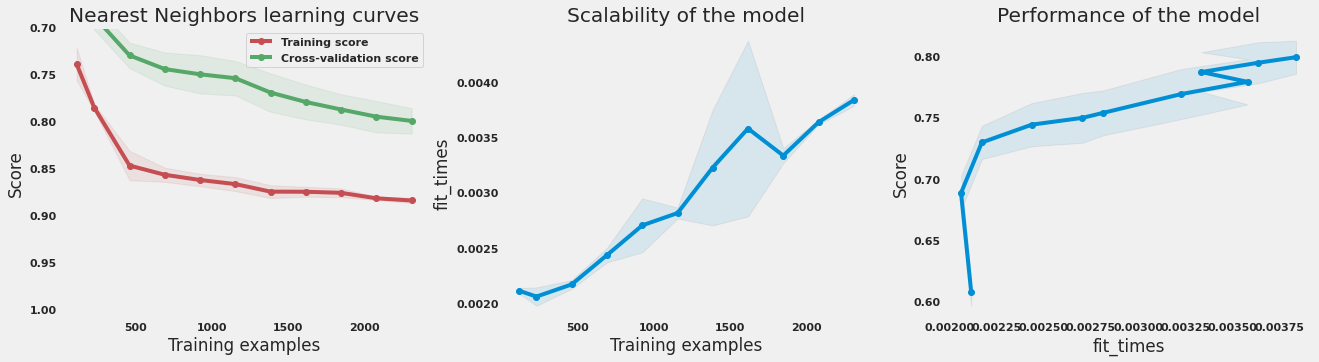

In [61]:
g = plot_learning_curve1(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

#### 5.4.1 Decision Tree Algorithm

In [0]:
##### Decision Trees #####
class DecisionNode():
    """Class that represents a decision node or leaf in the decision tree

    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i          # Index for the feature that is tested
        self.threshold = threshold          # Threshold value for feature
        self.value = value                  # Value if the node is a leaf in the tree
        self.true_branch = true_branch      # 'Left' subtree
        self.false_branch = false_branch    # 'Right' subtree


# Super class of RegressionTree and ClassificationTree
class DecisionTree(object):
    """Super class of RegressionTree and ClassificationTree.

    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None  # Root node in dec. tree
        # Minimum n of samples to justify split
        self.min_samples_split = min_samples_split
        # The minimum impurity to justify split
        self.min_impurity = min_impurity
        # The maximum depth to grow the tree to
        self.max_depth = max_depth
        # Function to calculate impurity (classif.=>info gain, regr=>variance reduct.)
        self._impurity_calculation = None
        # Function to determine prediction of y at leaf
        self._leaf_value_calculation = None
        # If y is one-hot encoded (multi-dim) or not (one-dim)
        self.one_dim = None
        # If Gradient Boost
        self.loss = loss

    def fit(self, X, y, loss=None):
        """ Build decision tree """
        self.one_dim = len(np.shape(y)) == 1
        self.root = self._build_tree(X, y)
        self.loss=None

    def _build_tree(self, X, y, current_depth=0):
        """ Recursive method which builds out the decision tree and splits X and respective y
        on the feature of X which (based on impurity) best separates the data"""

        largest_impurity = 0
        best_criteria = None    # Feature index and threshold
        best_sets = None        # Subsets of the data

        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            # Calculate the impurity for each feature
            for feature_i in range(n_features):
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterate through all unique values of feature column i and
                # calculate the impurity
                for threshold in unique_values:
                    # Divide X and y depending on if the feature value of X at index feature_i
                    # meets the threshold
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:, n_features:]
                        y2 = Xy2[:, n_features:]

                        # Calculate impurity
                        impurity = self._impurity_calculation(y, y1, y2)

                        # If this threshold resulted in a higher information gain than previously
                        # recorded save the threshold value and the feature
                        # index
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i": feature_i, "threshold": threshold}
                            best_sets = {
                                "leftX": Xy1[:, :n_features],   # X of left subtree
                                "lefty": Xy1[:, n_features:],   # y of left subtree
                                "rightX": Xy2[:, :n_features],  # X of right subtree
                                "righty": Xy2[:, n_features:]   # y of right subtree
                                }

        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            true_branch = self._build_tree(best_sets["leftX"], best_sets["lefty"], current_depth + 1)
            false_branch = self._build_tree(best_sets["rightX"], best_sets["righty"], current_depth + 1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria[
                                "threshold"], true_branch=true_branch, false_branch=false_branch)

        # We're at leaf => determine value
        leaf_value = self._leaf_value_calculation(y)

        return DecisionNode(value=leaf_value)


    def predict_value(self, x, tree=None):
        """ Do a recursive search down the tree and make a prediction of the data sample by the
            value of the leaf that we end up at """

        if tree is None:
            tree = self.root

        # If we have a value (i.e we're at a leaf) => return value as the prediction
        if tree.value is not None:
            return tree.value

        # Choose the feature that we will test
        feature_value = x[tree.feature_i]

        # Determine if we will follow left or right branch
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.true_branch
        elif feature_value == tree.threshold:
            branch = tree.true_branch

        # Test subtree
        return self.predict_value(x, branch)

    def predict(self, X):
        """ Classify samples one by one and return the set of labels """
        y_pred = [self.predict_value(sample) for sample in X]
        return y_pred

#### 5.4.2 Decision Tree Output

In [63]:
tr = Class_Fit(clf = DecisionTree)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 86.15 % 


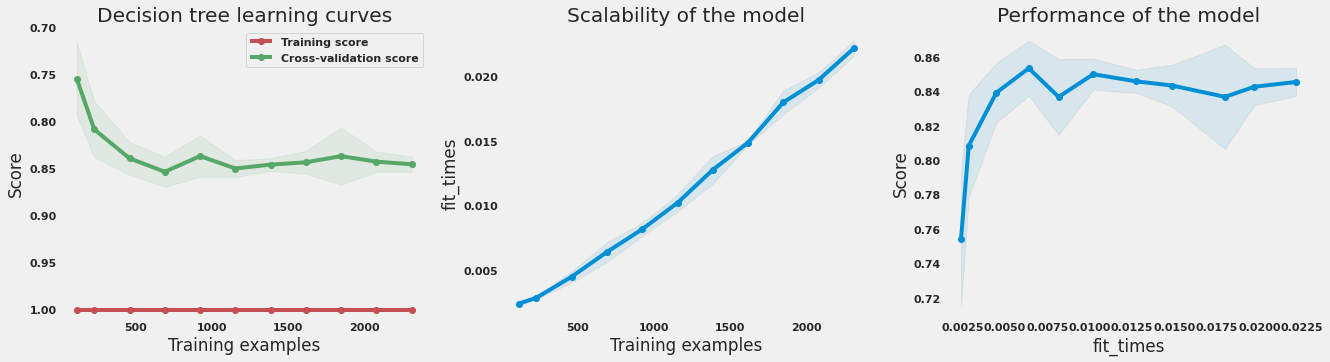

In [64]:
g = plot_learning_curve1(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

### 5.5.1 Random Forest Algorithm


In [0]:
class RandomForest():
    """Random Forest classifier. Uses a collection of classification trees that
    trains on random subsets of the data using a random subsets of the features.

    """
    def __init__(self, n_estimators=100, max_features=None, min_samples_split=2,
                 min_gain=0, max_depth=float("inf")):
        self.n_estimators = n_estimators    # Number of trees
        self.max_features = max_features    # Maxmimum number of features per tree
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain            # Minimum information gain req. to continue
        self.max_depth = max_depth          # Maximum depth for tree
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        # Initialize decision trees
        self.trees = []
        for _ in range(n_estimators):
            self.trees.append(
                ClassificationTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_gain,
                    max_depth=self.max_depth))

    def fit(self, X, y):
        n_features = np.shape(X)[1]
        # If max_features have not been defined => select it as
        # sqrt(n_features)
        if not self.max_features:
            self.max_features = int(math.sqrt(n_features))

        # Choose one random subset of the data for each tree
        subsets = get_random_subsets(X, y, self.n_estimators)

        for i in self.progressbar(range(self.n_estimators)):
            X_subset, y_subset = subsets[i]
            # Feature bagging (select random subsets of the features)
            idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
            # Save the indices of the features for prediction
            self.trees[i].feature_indices = idx
            # Choose the features corresponding to the indices
            X_subset = X_subset[:, idx]
            # Fit the tree to the data
            self.trees[i].fit(X_subset, y_subset)

    def predict(self, X):
        y_preds = np.empty((X.shape[0], len(self.trees)))
        # Let each tree make a prediction on the data
        for i, tree in enumerate(self.trees):
            # Indices of the features that the tree has trained on
            idx = tree.feature_indices
            # Make a prediction based on those features
            prediction = tree.predict(X[:, idx])
            y_preds[:, i] = prediction
            
        y_pred = []
        # For each sample
        for sample_predictions in y_preds:
            # Select the most common class prediction
            y_pred.append(np.bincount(sample_predictions.astype('int')).argmax())
        return y_pred

### 5.5.2 Random Forest Output

In [66]:
rf = Class_Fit(clf = RandomForest)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 89.89 % 


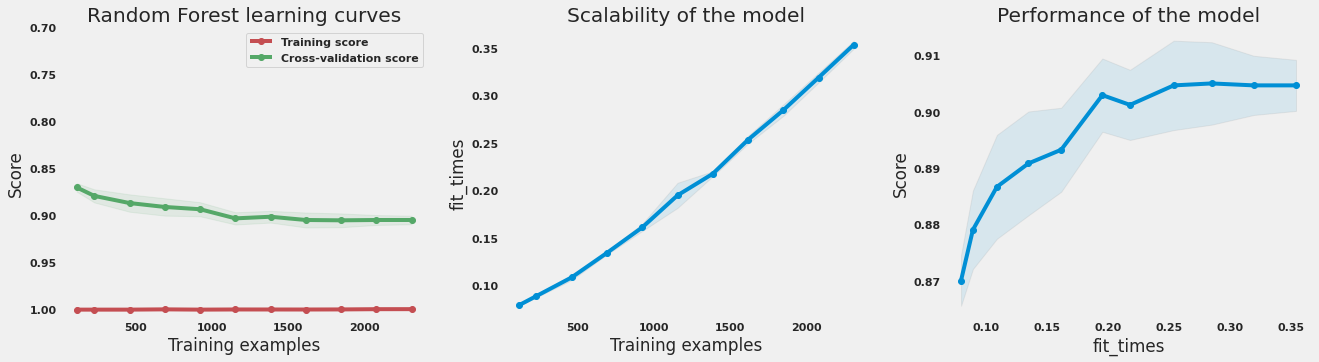

In [67]:
g = plot_learning_curve1(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [0]:
class DecisionStump():
    def __init__(self):
        # Determines if sample shall be classified as -1 or 1 given threshold
        self.polarity = 1
        # The index of the feature used to make classification
        self.feature_index = None
        # The threshold value that the feature should be measured against
        self.threshold = None
        # Value indicative of the classifier's accuracy
        self.alpha = None

class Adaboost():
    """Boosting method that uses a number of weak classifiers in 
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree. 

    """
    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))
        
        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            # Minimum error given for using a certain feature value threshold
            # for predicting sample label
            min_error = float('inf')
            # Iterate throught every unique feature value and see what value
            # makes the best threshold for predicting y
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # Try every unique feature value as threshold
                for threshold in unique_values:
                    p = 1
                    # Set all predictions to '1' initially
                    prediction = np.ones(np.shape(y))
                    # Label the samples whose values are below threshold as '-1'
                    prediction[X[:, feature_i] < threshold] = -1
                    # Error = sum of weights of misclassified samples
                    error = sum(w[y != prediction])
                    
                    # If the error is over 50% we flip the polarity so that samples that
                    # were classified as 0 are classified as 1, and vice versa
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # If this threshold resulted in the smallest error we save the
                    # configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Calculate new weights 
            # Missclassified samples gets larger weights and correctly classified samples smaller
            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y_pred))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf.alpha * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()

        return y_pred

In [69]:
ada = Class_Fit(clf = Adaboost)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 55.82 % 


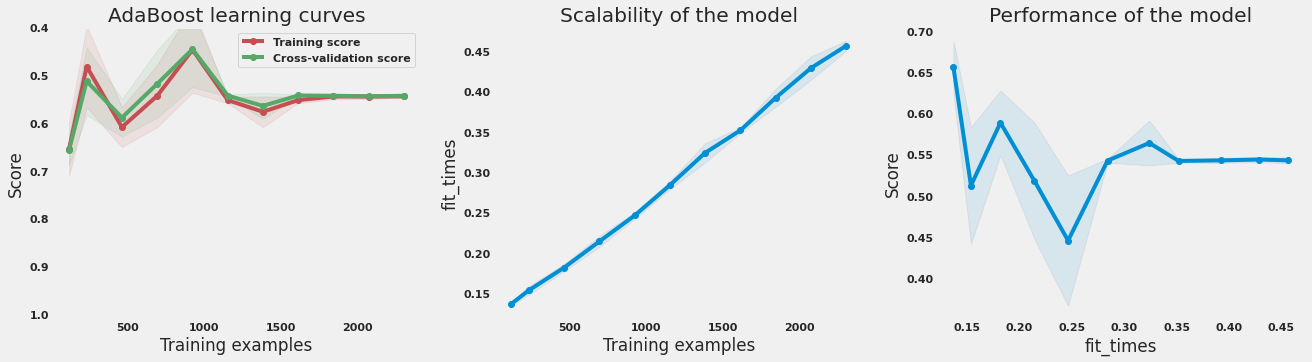

In [70]:
g = plot_learning_curve1(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


### 5.7 Gradient Boosting Classifier

In [0]:
class GradientBoosting(object):
    """Super class of GradientBoostingClassifier and GradientBoostinRegressor. 
    Uses a collection of regression trees that trains on predicting the gradient
    of the loss function. 

    """
    def __init__(self, n_estimators, learning_rate, min_samples_split,
                 min_impurity, max_depth, regression):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.regression = regression
        self.bar = progressbar.ProgressBar(widgets=bar_widgets)
        
        # Square loss for regression
        # Log loss for classification
        self.loss = SquareLoss()
        if not self.regression:
            self.loss = CrossEntropy()

        # Initialize regression trees
        self.trees = []
        for _ in range(n_estimators):
            tree = RegressionTree(
                    min_samples_split=self.min_samples_split,
                    min_impurity=min_impurity,
                    max_depth=self.max_depth)
            self.trees.append(tree)


    def fit(self, X, y):
        y_pred = np.full(np.shape(y), np.mean(y, axis=0))
        for i in self.bar(range(self.n_estimators)):
            gradient = self.loss.gradient(y, y_pred)
            self.trees[i].fit(X, gradient)
            update = self.trees[i].predict(X)
            # Update y prediction
            y_pred -= np.multiply(self.learning_rate, update)


    def predict(self, X):
        y_pred = np.array([])
        # Make predictions
        for tree in self.trees:
            update = tree.predict(X)
            update = np.multiply(self.learning_rate, update)
            y_pred = -update if not y_pred.any() else y_pred - update

        if not self.regression:
            # Turn into probability distribution
            y_pred = np.exp(y_pred) / np.expand_dims(np.sum(np.exp(y_pred), axis=1), axis=1)
            # Set label to the value that maximizes probability
            y_pred = np.argmax(y_pred, axis=1)
        return y_pred


In [72]:
gb = Class_Fit(clf = GradientBoosting)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 89.47 % 


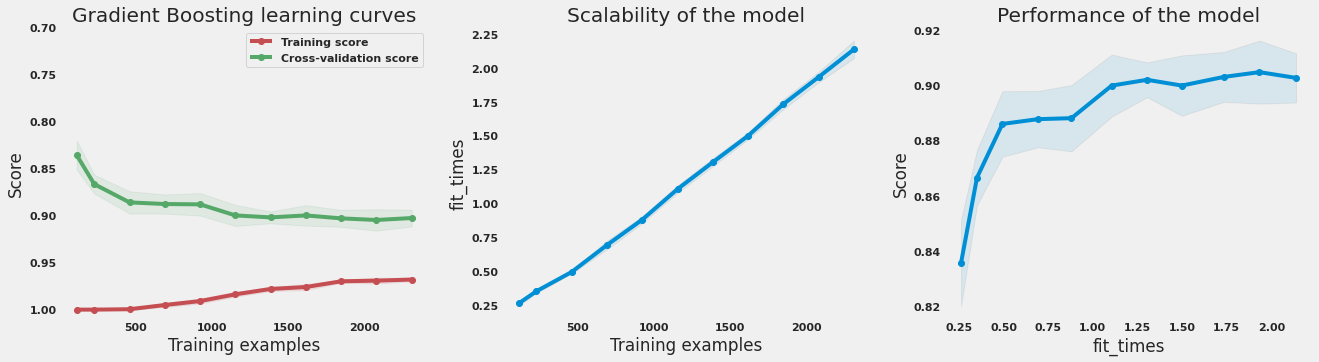

In [73]:
g = plot_learning_curve1(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.8 Voting Classifier

In [0]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

In [0]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft') 

In [0]:
votingC = votingC.fit(X_train, Y_train)

In [77]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.00 % 


# 6.Testing Predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model the last two months of the dataset, that has been stored in the set_test dataframe

In [0]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set

In [79]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket_Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,20.017905,32.343299,12.696657,10.670511,24.271627
1,12349,5,1757.55,1757.55,1757.55,8787.75,26.506216,12.245455,4.513101,46.021450,10.713778
2,12352,5,311.73,311.73,311.73,1558.65,34.420813,8.735123,6.672441,42.953838,7.217785
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,0.000000,100.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,18.475531,14.684737,5.089832,33.399810,28.350089


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [0]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories

In [0]:
Y = kmeans.predict(scaled_test_matrix)
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [82]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 65.50 % 
______________________________ 
Logostic Regression
Precision: 75.54 % 
______________________________ 
k-Nearest Neighbors
Precision: 67.19 % 
______________________________ 
Decision Tree
Precision: 71.38 % 
______________________________ 
Random Forest
Precision: 75.42 % 
______________________________ 
Gradient Boosting
Precision: 75.58 % 


In [83]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 76.21 % 


# 7.Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately  ∼ 4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:

** mean **: amount of the basket of the current purchase
** categ_N ** with  N∈[0:4] : percentage spent in product category with index  N 


Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 75% of clients are awarded the right classes. The performance of the classifier therefore seems correct given the potential shortcomings of the current model. 